# Compare different sequential models

Author: Thorsten Kalb

This Notebook should execute the functions given in movielens_sequence and evaluate the validation accuracy.
It will be used later to compare the sequential models to the explicit model.

In [1]:
from spotlight.cross_validation import user_based_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import sequence_mrr_score
from spotlight.sequence.implicit import ImplicitSequenceModel
import matplotlib.pyplot as plt
import numpy as np
import sys
import mlflow
from mlflow import log_metric, log_param, log_artifact
import torch

dataset_name = '100K'     ### update this line to say from WHEN the data is!
dataset = get_movielens_dataset(dataset_name)
mlflow.set_tracking_uri('./mlruns')

C:\Users\Uni\anaconda3\envs\AgileData\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.
  


A new experiment was created.


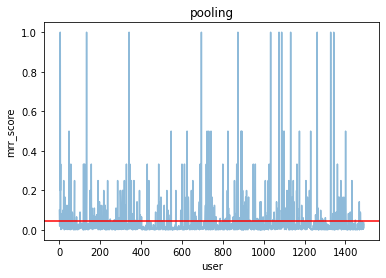

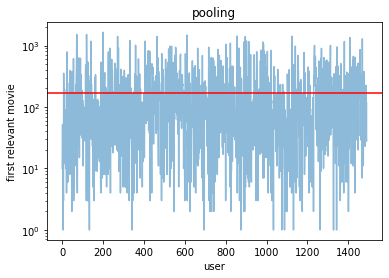

Mean mrr validation score: 0.0469 for model pooling
On average, the first relevant movie in the predicted sequence is at place 165.7940979208585 for model pooling


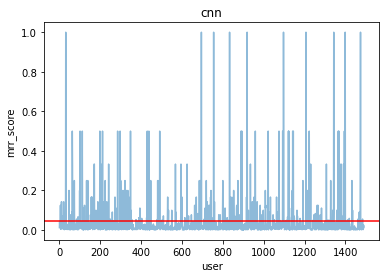

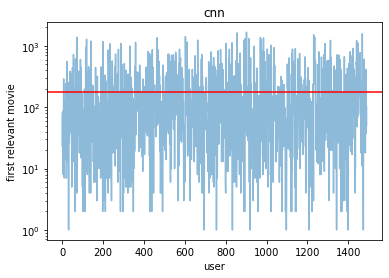

Mean mrr validation score: 0.0459 for model cnn
On average, the first relevant movie in the predicted sequence is at place 177.42119382964452 for model cnn


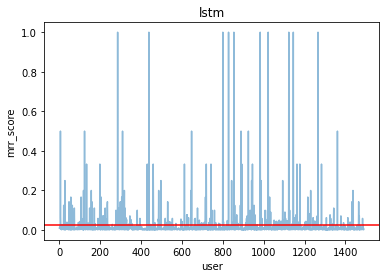

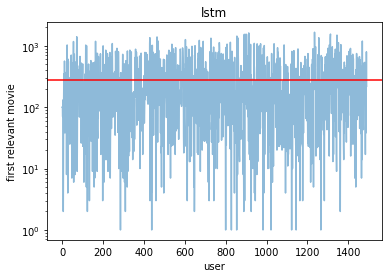

Mean mrr validation score: 0.0278 for model lstm
On average, the first relevant movie in the predicted sequence is at place 275.7786720321932 for model lstm


In [2]:
train_valid, test = user_based_train_test_split(dataset)

train, validation = user_based_train_test_split(train_valid)

train = train.to_sequence()
validation = validation.to_sequence()
test = test.to_sequence()
train_valid = train_valid.to_sequence()

sequmods = ['pooling','cnn','lstm']


experiment_name = "Spotlight_Movielense_Sqeuence_Validation"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
    print("A new experiment was created.")
except:
    current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
    experiment_id=current_experiment['experiment_id']
    print("The experiment already exists. Continue with the existing experiment.")
for repres in sequmods:
    with mlflow.start_run(experiment_id=experiment_id):
        n_iter=50
        loss='bpr'
        model = ImplicitSequenceModel(n_iter=n_iter, #10 #5 #3 #50
                                  representation=repres,
                                  loss=loss)
        model.fit(train)
        mrr_train = sequence_mrr_score(model, train) # the training metrics, useful for overfitting!
        invmrr_train = np.zeros(mrr_train.shape)
        invmrr_train[mrr_train>0.0] = 1/mrr_train[mrr_train>0.0]
        mean_mrr_train = np.mean(mrr_train)
        log_metric("mean_mrr_train",mean_mrr_train)
        
        mrr = sequence_mrr_score(model, validation)
        invmrr = np.zeros(mrr.shape)
        invmrr[mrr>0.0] = 1/mrr[mrr>0.0]
        
        mean_mrr = np.mean(mrr)
        mean_invmrr = np.mean(invmrr)
        # log the model's parameters in mlflow
        log_param("dataset_name",dataset_name)
        log_param("n_iter",n_iter)
        log_param("loss",loss)
        log_metric("mean_mrr",mean_mrr)
        log_metric("mean_invmrr",mean_invmrr)
        log_param("model_type",repres)
        #torch.save(model, "./saved_model")
        #log_artifact("model_object",model) # requires a dfbs path
        # plot the performance
        
        # plot mrr score
        plt.plot(mrr,alpha=0.5)
        plt.title(repres)
        plt.xlabel("user")
        plt.ylabel("mrr_score")
        plt.axhline(y=mean_mrr, color='r', linestyle='-')
        plt.show()
        
        # plot 1/mrr as an index of first relevant movie
        plt.plot(invmrr,alpha=0.5)
        plt.title(repres)
        plt.xlabel("user")
        plt.ylabel("first relevant movie")
        plt.axhline(y=mean_invmrr, color='r', linestyle='-')
        plt.yscale('log')
        plt.show()
        print("Mean mrr validation score: {:.4f} for model {}".format(mean_mrr,repres))
        print("On average, the first relevant movie in the predicted sequence is at place {} for model {}".format(mean_invmrr,repres))
    #mlflow.end_run()


In [3]:
#!mlflow ui --backend-store-uri ./mlruns

## Result:

It depends a lot on the **number of epochs** during training, which model performs better. However, for few iterations, the CNN and lstm have an average mrr score of 0.2m while the pooling model has an average mrr score of 0.4. For more epochs, the validation mrr score increases for all models. 

For 50 epochs, I report a mrr scores of 0.058, 0.056 and 0.023 for the pooling, cnn and lstm models, respectively. 
For 100 epochs, I report mrr scores of 0.055, 0.043 and 0.045 for the pooling, cnn and lstm models, respectively.
For a better comparison, these experiments should be saved in a docker image with fixed seed etc. 

I propose **new metrics** for the evaluation here, namely, when does the **first relevant movie** appear in the list, on average. Therefore, I take the average over users of all the inverses of the mrr_scores, wherever the inverse exists.

Thus, I would **choose the Pooling model**. The advantage is a higher starting mrr score and a consistently higher mrr score, which means we do not need to train the model a lot and thus, it is quickly accesible and highly adaptable to new data.

A **direct comparison with the Explicit model is not (yet) possible**. This is, because of the different nature of the models: Sequential models try to predict the next element of a sequence, whereas the explicit model tries to predict the rating of the user on a movie that the user has not yet seen. Perhaps in the future, we can work on a way to compare the models, e.g. by ordering the rankings from the explicit model and turning this into a sequence?

Interestingly, the **mrr scores change for bigger datasets**, resulting in CNN outperforming the pooling, for the given 50 training epochs and evaluating the mean of the mrr score. Interestingly, the mean place, with the first relevant movie is still better for the pooling model for the 1M dataset. The LSTM model worsens in both aspects significantly for the 1M dataset.


In [ ]:
# torch.save(x, "./saved_model.pt")

In [4]:
model2 = torch.load("./saved_model.pt")
mrr = sequence_mrr_score(model2, validation)
print(np.mean(mrr))

0.022954418832050516


# Try the MLflow Client

In [3]:
from mlflow.tracking import MlflowClient
client = MlflowClient()

runs = client.search_runs(experiment_id, order_by=["metrics.mean_invmrr ASC"])


In [4]:
def print_run_info(runs):
    for r in runs:
        print("run_id: {}".format(r.info.run_id))
        print("lifecycle_stage: {}".format(r.info.lifecycle_stage))
        print("metrics: {}".format(r.data.metrics))
        print("parameters {}".format(r.data.params))
print_run_info(runs)


run_id: eecda929a2e64934b0dbf642762bfe5f
lifecycle_stage: active
metrics: {'mean_invmrr': 165.7940979208585, 'mean_mrr': 0.046911749538356466, 'mean_mrr_train': 0.05530945683863712}
parameters {'dataset_name': '100K', 'loss': 'bpr', 'model_type': 'pooling', 'n_iter': '50'}
run_id: b9896f4196ab4b8e9c27ac38a915c5a2
lifecycle_stage: active
metrics: {'mean_invmrr': 177.42119382964452, 'mean_mrr': 0.04593488078777315, 'mean_mrr_train': 0.058398718796511914}
parameters {'dataset_name': '100K', 'loss': 'bpr', 'model_type': 'cnn', 'n_iter': '50'}
run_id: dd2b52f5018d4f4fb79228365915c56e
lifecycle_stage: active
metrics: {'mean_invmrr': 275.7786720321932, 'mean_mrr': 0.02783395843491129, 'mean_mrr_train': 0.029611377580049673}
parameters {'dataset_name': '100K', 'loss': 'bpr', 'model_type': 'lstm', 'n_iter': '50'}


In [5]:
df = mlflow.search_runs([experiment_id], order_by=["metrics.mean_invmrr ASC","metrics.mean_mrr DESC"])
print(df)
best_run_id = df.loc[0,'run_id']

                             run_id experiment_id    status  \
0  eecda929a2e64934b0dbf642762bfe5f             2  FINISHED   
1  b9896f4196ab4b8e9c27ac38a915c5a2             2  FINISHED   
2  dd2b52f5018d4f4fb79228365915c56e             2  FINISHED   

                                        artifact_uri  \
0  ./mlruns/2/eecda929a2e64934b0dbf642762bfe5f/ar...   
1  ./mlruns/2/b9896f4196ab4b8e9c27ac38a915c5a2/ar...   
2  ./mlruns/2/dd2b52f5018d4f4fb79228365915c56e/ar...   

                        start_time                         end_time  \
0 2022-12-16 09:18:58.125000+00:00 2022-12-16 09:19:37.051000+00:00   
1 2022-12-16 09:19:37.051000+00:00 2022-12-16 09:21:06.925000+00:00   
2 2022-12-16 09:21:06.933000+00:00 2022-12-16 09:22:48.075000+00:00   

   metrics.mean_mrr  metrics.mean_invmrr  metrics.mean_mrr_train  \
0          0.046912           165.794098                0.055309   
1          0.045935           177.421194                0.058399   
2          0.027834           275

In [6]:
best_run = client.get_run(best_run_id)
print(best_run.data.params)

{'dataset_name': '100K', 'loss': 'bpr', 'model_type': 'pooling', 'n_iter': '50'}


## Retrain the model with best parameters
Here, I want to retrain the best model on train and validation and report its testing accuracy!

In [13]:
def get_best_params(experiment_id):
    """requires an experiment_id and gives the parameters of the best run of this experiment as a dictionary"""
    client = MlflowClient()
    runs = mlflow.search_runs([experiment_id], order_by=["metrics.mean_invmrr ASC","metrics.mean_mrr DESC"])
    best_run_id = runs.loc[0,'run_id']
    best_run = client.get_run(best_run_id)
    params=best_run.data.params
    return params

def report_test_mrr(experiment_id, train_valid, test):
    params = get_best_params(experiment_id)
    print("Optimal parameters obtained succesfully. Start training now.")
    n_iter, model_type, loss = params["n_iter"], params["model_type"], params["loss"]
    n_iter = int(n_iter)
    model = ImplicitSequenceModel(n_iter=n_iter, #10 #5 #3 #50
                                  representation=model_type,
                                  loss=loss)
    # train the model with given parameters on train and validation
    model.fit(train_valid)
    # create test_acc
    test_mrr = sequence_mrr_score(model, test)
    return test_mrr

test_mrr = report_test_mrr(experiment_id, train_valid, test)

Optimal parameters obtained succesfully. Start training now.


In [14]:
print(np.mean(test_mrr))

0.04931730195498784


In [20]:
repres = 'pooling'
n_iter=1
loss='bpr'
model2 = ImplicitSequenceModel(n_iter=n_iter, #10 #5 #3 #50
                          representation=repres,
                          loss=loss)
model2.fit(train_valid)
mrr_test = sequence_mrr_score(model, test) # the training metrics, useful for overfitting!

In [21]:
print(np.mean(mrr_test))

0.021457790953294295
